In [1]:
from datetime import datetime, timedelta
import string

import asilib
import asilib.map
import asilib.asi
import matplotlib.dates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import IRBEM
import numpy as np
import pandas as pd
import pyspedas
import manylabels
import aacgmv2

import elfinasi

c:\Users\shumkms1\AppData\Local\anaconda3\envs\asilib_dev_20241108\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
R_E = 6378.137  # km
time_range = ('2022-09-04T04:23:00', '2022-09-04T04:28:00')
plot_times = (
    datetime(2022, 9, 4, 4, 24, 00),
    datetime(2022, 9, 4, 4, 25, 00),
    datetime(2022, 9, 4, 4, 25, 50),
    datetime(2022, 9, 4, 4, 27, 00),
)
location_codes = ('ATHA', 'PINA', 'GILL', 'RABB', 'LUCK')
poes_probe = 'noaa18'
alt=90

In [3]:
def map_poes(df, alt=110, hemi_flag=0):
    """
    Map POES's location along the magnetic field line to alt using IRBEM.MagFields.find_foot_print.

    Parameters
    ----------
    alt: float
        The mapping altitude in units of kilometers
    hemi_flag: int
        What direction to trace the field line: 
        0 = same magnetic hemisphere as starting point
        +1   = northern magnetic hemisphere
        -1   = southern magnetic hemisphere
        +2   = opposite magnetic hemisphere as starting point
    """
    m = IRBEM.MagFields(kext='T89')
    _all = np.zeros_like(df.loc[:, ['alt', 'lat', 'lon']])

    for i, (time, row) in enumerate(df.iterrows()):
        X = {'Time':time, 'x1':row['alt'], 'x2':row['lat'], 'x3':row['lon']}
        _all[i, :] = m.find_foot_point(X, {'Kp':56}, alt, hemi_flag)['XFOOT']
    _all[_all == -1E31] = np.nan
    mapped_df = df.copy()
    mapped_df.loc[:, ['alt', 'lat', 'lon']] = _all
    return mapped_df

In [4]:
sem_vars = pyspedas.poes.sem(trange=time_range, probe=poes_probe, time_clip=True, no_update=True)

24-Mar-25 10:53:00: Searching for local files...


In [5]:
ephemeris_df = pd.DataFrame(
    index=pyspedas.data_quants['lat'].time,
    data={
        'alt':pyspedas.data_quants['alt'].to_numpy(),
        'lat':pyspedas.data_quants['lat'].to_numpy(),
        'lon':pyspedas.data_quants['lon'].to_numpy(),
    }
)
mapped_ephemeris = map_poes(ephemeris_df, alt=alt)

aacgm_lats = aacgmv2.convert_latlon_arr(
        ephemeris_df.lat,
        ephemeris_df.lon,
        ephemeris_df.alt,
        pd.to_datetime(ephemeris_df.index).to_pydatetime()[0],
        method_code="G2A",
    )[0]
mapped_ephemeris['mlat'] = aacgm_lats

manylabels_data = pd.DataFrame(
    index=mapped_ephemeris.index,
    data={
        'Alt [km]':mapped_ephemeris.alt,
        f'Geo Lat [$\\circ$]':mapped_ephemeris.lat,
        f'Geo Lon [$\\circ$]':mapped_ephemeris.lon,
        f'$\\lambda$ [$\\circ$]':mapped_ephemeris.mlat.astype(np.float32),
        }
).round(2)

In [6]:
manylabels_data.tail()

,Alt [km],Geo Lat [$\circ$],Geo Lon [$\circ$],$\lambda$ [$\circ$]
2022-09-04 04:27:50.163000064,89.919998,62.119999,-108.699997,69.160004
2022-09-04 04:27:52.163000064,89.940002,62.220001,-108.779999,69.250000
2022-09-04 04:27:54.163000064,89.930000,62.330002,-108.870003,69.330002
2022-09-04 04:27:56.163000064,89.919998,62.430000,-108.949997,69.419998
2022-09-04 04:27:58.163000064,89.980003,62.540001,-109.040001,69.510002


Read in Ying's MEPED files

In [7]:
meped_df = pd.read_csv(
    elfinasi.data_dir / '20220904noaa18mep.txt',
    sep="\\s+",
    parse_dates=True,
    index_col=0,
    date_format='%Y-%m-%d/%H:%M:%S'
    )
meped_flux_units = '#/cm2-s-str'
meped_df = meped_df.rename(columns={'flux_at_tel0_#/cm2-s-str':'flux_at_tel0'})

In [8]:
meped_df.head()

,energy_keV,flux_at_tel0,flux_at_tel90,flux_error_at_tel0,flux_error_at_tel90,alt,lat,lon
time,,,,,,,,
2022-09-04 04:20:00,40,241.94,95443.55,76.0,50.0,851.3,34.12,263.16
2022-09-04 04:20:00,130,138.89,62743.05,74.0,22.0,851.3,34.12,263.16
2022-09-04 04:20:00,287,0.00,7466.67,0.0,29.0,851.3,34.12,263.16
2022-09-04 04:20:00,612,363.64,0.00,101.0,0.0,851.3,34.12,263.16
2022-09-04 04:20:02,40,403.23,90282.26,67.0,50.0,851.3,34.24,263.13


In [9]:
# The energy channel values are from the bowtie analysis
# (https://www.ngdc.noaa.gov/stp/satellite/poes/docs/NGDC/MEPED%20telescope%20processing%20ATBD_V1.pdf)
meped_energy_channels = np.array(sorted(set(meped_df['energy_keV'])))
# E1-E3 channel labels from Yando+2011 (https://doi.org/10.1029/2011JA016671).
meped_energy_labels = np.array(['E1: >30', 'E2: >100', 'E3: >300'])

In [10]:
ted_high_0tel = pyspedas.data_quants['ted_ele_tel0_hi_eflux']
ted_low_0tel = pyspedas.data_quants['ted_ele_tel0_low_eflux']

In [11]:
manylabels_data

,Alt [km],Geo Lat [$\circ$],Geo Lon [$\circ$],$\lambda$ [$\circ$]
2022-09-04 04:23:00.163000064,89.099998,46.730000,-100.110001,55.540001
2022-09-04 04:23:02.163000064,89.989998,46.830002,-100.150002,55.639999
2022-09-04 04:23:04.163000064,89.970001,46.939999,-100.199997,55.730000
2022-09-04 04:23:06.163000064,90.000000,47.040001,-100.239998,55.830002
2022-09-04 04:23:08.163000064,90.000000,47.150002,-100.279999,55.930000
...,...,...,...,...
2022-09-04 04:27:50.163000064,89.919998,62.119999,-108.699997,69.160004
2022-09-04 04:27:52.163000064,89.940002,62.220001,-108.779999,69.250000
2022-09-04 04:27:54.163000064,89.930000,62.330002,-108.870003,69.330002
2022-09-04 04:27:56.163000064,89.919998,62.430000,-108.949997,69.419998


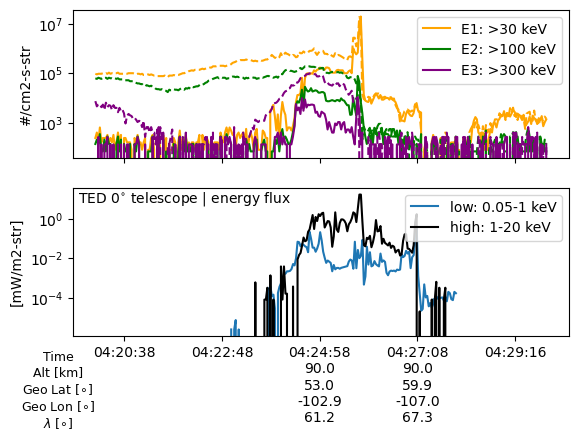

In [12]:
fig, bx = plt.subplots(2, 1, sharex=True)
colors = ('orange', 'green', 'purple', 'black')
for _channel, color, energy_label in zip(meped_energy_channels, colors, meped_energy_labels):
    # Pick out fluxes for that energy channel
    flux_0deg = meped_df[meped_df['energy_keV'] == _channel]['flux_at_tel0']
    flux_90deg = meped_df[meped_df['energy_keV'] == _channel]['flux_at_tel90']
    bx[0].plot(flux_0deg.index, flux_0deg, color=color, label=f'{energy_label} keV')
    bx[0].plot(flux_90deg.index, flux_90deg, color=color, ls='--')

bx[1].plot(ted_low_0tel.time, ted_low_0tel.values, label='low: 0.05-1 keV')
bx[1].plot(ted_high_0tel.time, ted_high_0tel.values, c='k', label='high: 1-20 keV')
bx[1].text(0.01, 0.99, f'TED $0^{{\\circ}}$ telescope | energy flux', va='top', transform=bx[1].transAxes)
bx[0].set_yscale('log')
bx[0].set_ylabel(meped_flux_units)
bx[1].set_yscale('log')
bx[1].set_ylabel(ted_high_0tel.plot_options['yaxis_opt']['axis_subtitle'])
bx[0].legend();
bx[1].legend(loc=1);
manylabels.ManyLabels(bx[1], manylabels_data)
bx[1].xaxis.label.set_size(9)
bx[1].xaxis.set_label_coords(-0.03, -0.02*(1+len(manylabels_data.columns)))
bx[1].xaxis.set_major_locator(plt.MaxNLocator(7))

In [13]:
asis = asilib.Imagers(
        [asilib.asi.trex_rgb(location_code=location_code, time=time_range[0], alt=alt) 
        for location_code in location_codes]
        )

Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


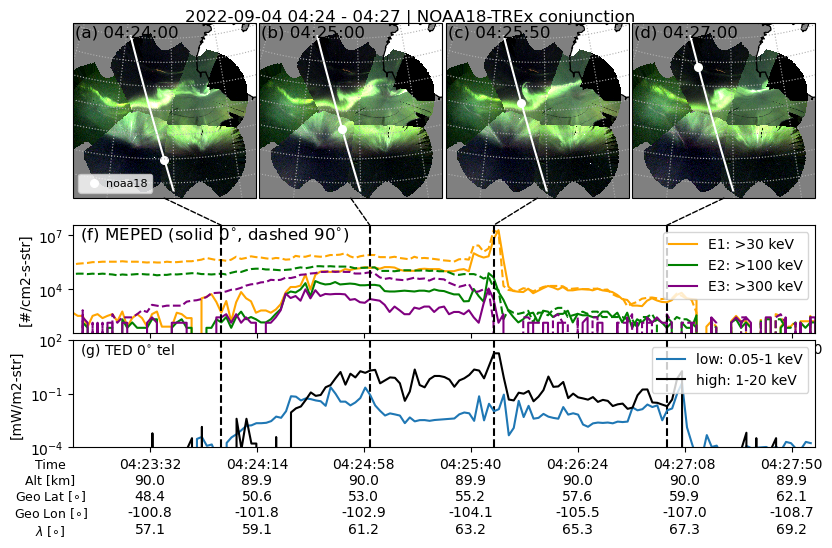

In [14]:
fig = plt.figure(figsize=(9, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(3, len(plot_times),
                      right=0.95, bottom=0.25, top=0.99,
                      wspace=0.02, hspace=0.05,
                      height_ratios=(2, 1, 1))

ax = [
    asilib.map.create_map(
        lon_bounds=(-115, -88), 
        lat_bounds=(45, 63.5), 
        fig_ax=(fig, gs[0, i],),
        land_color='grey'
        ) for i in range(gs.ncols)
    ]
bx = fig.add_subplot(gs[1, :])
cx = fig.add_subplot(gs[2, :], sharex=bx)

ephemeris_indices = mapped_ephemeris.index.get_indexer(plot_times, method='nearest')
mapped_ephemeris_snapshots = mapped_ephemeris.iloc[ephemeris_indices, :]

for i, (time, ax_i, _label) in enumerate(zip(plot_times, ax, string.ascii_lowercase)):
    asis = asilib.Imagers(
        [asilib.asi.trex_rgb(location_code=location_code, time=time, alt=alt) 
        for location_code in location_codes]
        )
    vmin = min([_imager.get_color_bounds()[0] for _imager in asis.imagers])
    vmax = max([_imager.get_color_bounds()[1] for _imager in asis.imagers])
    asis.plot_map(
        ax=ax_i, 
        min_elevation=7, 
        pcolormesh_kwargs={'rasterized':True}, 
        asi_label=False, 
        color_bounds=(vmin, vmax)
        )
    
    ax_i.plot(mapped_ephemeris['lon'], mapped_ephemeris['lat'], c='w', transform=ccrs.PlateCarree())

    _noaa_loc = ax_i.scatter(
        mapped_ephemeris_snapshots.iloc[i]['lon'], 
        mapped_ephemeris_snapshots.iloc[i]['lat'], 
        c='w', 
        s=30,
        transform=ccrs.PlateCarree(),
        label=poes_probe
        )
    if not '_legend' in locals():
        _legend = ax[0].legend(loc='lower left', ncols=2, columnspacing=0.1, handletextpad=0.1, fontsize=8)
    _plot_time = ax_i.text(
        0.01, 0.99, f'({_label}) {time:%H:%M:%S}', va='top', transform=ax_i.transAxes, fontsize=12
        )
    
del(_legend)
colors = ('orange', 'green', 'purple', 'black')
for _channel, color, _label in zip(meped_energy_channels, colors, meped_energy_labels):
    # Pick out fluxes for that energy channel
    flux_0deg = meped_df[meped_df['energy_keV'] == _channel]['flux_at_tel0']
    flux_90deg = meped_df[meped_df['energy_keV'] == _channel]['flux_at_tel90']
    bx.plot(flux_0deg.index, flux_0deg, color=color, label=f'{_label} keV')
    bx.plot(flux_90deg.index, flux_90deg, color=color, ls='--')
bx.set_yscale('log')
bx.set_ylabel(f'[{meped_flux_units}]')
bx.set_xlim(plot_times[0]-timedelta(minutes=1), plot_times[-1]+timedelta(minutes=1))
bx.legend()

# Connect the subplots and add vertical lines to bx and cx.
for ax_i, image_time_numeric in zip(ax, matplotlib.dates.date2num(plot_times)):
    line = matplotlib.patches.ConnectionPatch(
        xyA=(0.5, 0), coordsA=ax_i.transAxes,
        xyB=(image_time_numeric, bx.get_ylim()[1]), coordsB=bx.transData, 
        ls='--')
    ax_i.add_artist(line)

    bx.axvline(image_time_numeric, c='k', ls='--')
    cx.axvline(image_time_numeric, c='k', ls='--')
_text = bx.text(
    0.01, 
    0.99, 
    (f'({string.ascii_lowercase[len(ax)+1]}) MEPED (solid $0^{{\\circ}}$, dashed $90^{{\\circ}}$)'), 
    va='top', 
    transform=bx.transAxes, 
    fontsize=12
    )

cx.plot(ted_low_0tel.time, ted_low_0tel.values, label='low: 0.05-1 keV')
cx.plot(ted_high_0tel.time, ted_high_0tel.values, c='k', label='high: 1-20 keV')
cx.text(0.01, 0.99, f'({string.ascii_lowercase[len(ax)+2]}) TED $0^{{\\circ}}$ tel', va='top', transform=cx.transAxes)
cx.set_yscale('log')
cx.set_ylabel(ted_high_0tel.plot_options['yaxis_opt']['axis_subtitle'])
cx.legend(loc=1)
cx.set_ylim(1E-4, 1E2)

manylabels.ManyLabels(cx, manylabels_data)
cx.xaxis.label.set_size(9)
cx.xaxis.set_label_coords(-0.03, -0.02*(1+len(manylabels_data.columns)))
cx.xaxis.set_major_locator(plt.MaxNLocator(7))
        
plt.suptitle(f'{plot_times[0]:%Y-%m-%d %H:%M} - {plot_times[-1]:%H:%M} | {poes_probe.upper()}-TREx conjunction');
plt.savefig(f'./plots/{plot_times[0]:%Y%m%d_%H%M}_{plot_times[-1]:%H%M}_{poes_probe.lower()}_trex_conjunction.png');

20220904_042300_042800_mosaic.mp4: |################################### | 98%
Animation saved to C:\Users\shumkms1\asilib-data\animations\20220904_042300_042800_mosaic.mp4


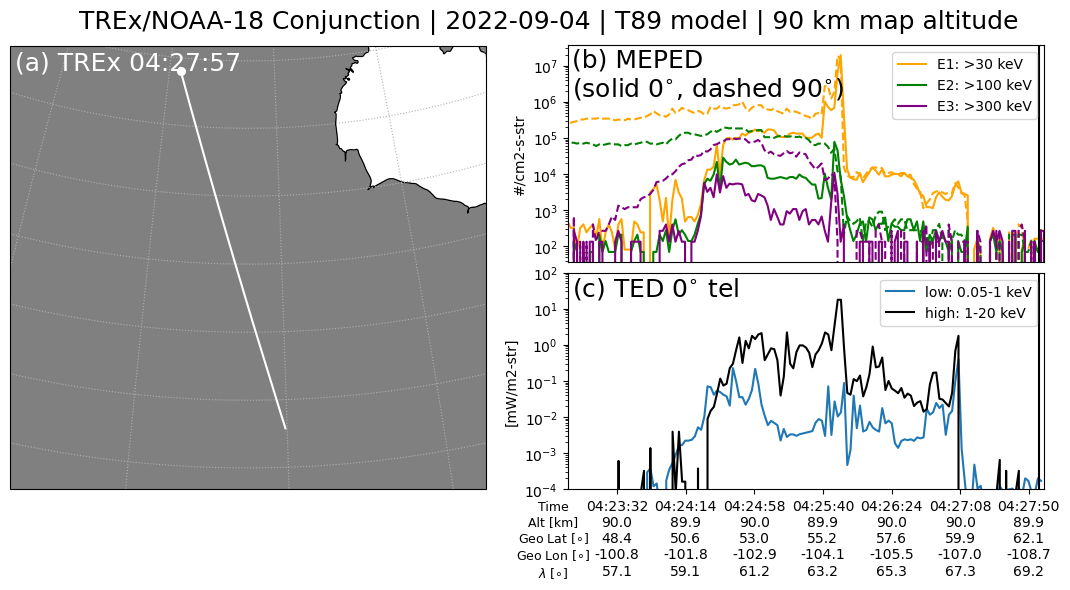

In [15]:
fig = plt.figure(figsize=(11, 6))
gs = fig.add_gridspec(2, 2,
                      left=0.01, right=0.95, bottom=0.18, top=0.92,
                      wspace=0.17, hspace=0.05, width_ratios=(1, 1)
                      )
ax = asilib.map.create_map(lon_bounds=(-117, -88), lat_bounds=(43, 63), fig_ax=(fig, gs[:, 0]), land_color='grey')
bx = fig.add_subplot(gs[0, 1])
cx = fig.add_subplot(gs[1, 1], sharex=bx)

asis = asilib.Imagers(
    [asilib.asi.trex_rgb(location_code=location_code, time_range=time_range, alt=alt) 
    for location_code in location_codes]
    )

plt.suptitle(f'TREx/NOAA-18 Conjunction | {time_range[0][:10]} | T89 model | {alt} km map altitude', fontsize=18)

ax.plot(mapped_ephemeris['lon'], mapped_ephemeris['lat'], c='w', transform=ccrs.PlateCarree(), zorder=2.01)
colors = ('orange', 'green', 'purple', 'black')
for _channel, color, _label in zip(meped_energy_channels, colors, meped_energy_labels):
    # Pick out fluxes for that energy channel
    flux_0deg = meped_df[meped_df['energy_keV'] == _channel]['flux_at_tel0']
    flux_90deg = meped_df[meped_df['energy_keV'] == _channel]['flux_at_tel90']
    bx.plot(flux_0deg.index, flux_0deg, color=color, label=f'{_label} keV')
    bx.plot(flux_90deg.index, flux_90deg, color=color, ls='--')
bx.text(
    0.01, 
    0.99, 
    f'({string.ascii_lowercase[1]}) MEPED\n(solid $0^{{\\circ}}$, dashed $90^{{\\circ}}$)', 
    va='top', 
    transform=bx.transAxes, 
    fontsize=18
    )
bx.set_yscale('log')
bx.set_ylabel(meped_flux_units)
bx.set_xlim(plot_times[0]-timedelta(minutes=1), plot_times[-1]+timedelta(minutes=1))
bx.legend()
bx.get_xaxis().set_visible(False)

cx.plot(ted_low_0tel.time, ted_low_0tel.values, label='low: 0.05-1 keV')
cx.plot(ted_high_0tel.time, ted_high_0tel.values, c='k', label='high: 1-20 keV')
cx.text(0.01, 0.99, f'({string.ascii_lowercase[2]}) TED $0^{{\\circ}}$ tel', va='top', transform=cx.transAxes, fontsize=18)
cx.set_yscale('log')
cx.set_ylabel(ted_high_0tel.plot_options['yaxis_opt']['axis_subtitle'])
cx.legend(loc=1)
cx.set_ylim(1E-4, 1E2)

manylabels.ManyLabels(cx, manylabels_data)
cx.xaxis.label.set_size(9)
cx.xaxis.set_label_coords(-0.03, -0.01*(1+len(manylabels_data.columns)))
cx.xaxis.set_major_locator(plt.MaxNLocator(7))

gen = asis.animate_map_gen(overwrite=True, ax=ax, min_elevation=7)
for _guide_time, _, _, _ in gen:
    if 'vline_bx' in locals():
        # These variables are only used when POES is in the FOV
        vline_bx.remove()
        vline_cx.remove()
        _noaa_loc.remove()
    
    if '_animation_plot_time' in locals():
        _animation_plot_time.remove()

    idx = mapped_ephemeris.index.get_indexer([_guide_time], method='nearest')
    _noaa_loc = ax.scatter(
        mapped_ephemeris.iloc[idx, :]['lon'], 
        mapped_ephemeris.iloc[idx, :]['lat'], 
        c='w',
        s=30,
        transform=ccrs.PlateCarree(),
        label=poes_probe
        )
    vline_bx = bx.axvline(_guide_time, c='k')
    vline_cx = cx.axvline(_guide_time, c='k')

    _animation_plot_time = ax.text(
        0.01, 0.99, f'({string.ascii_lowercase[0]}) TREx {_guide_time:%H:%M:%S}', 
        va='top', 
        transform=ax.transAxes, 
        fontsize=18,
        color='w'
        )